In [1]:
# "The social benefits of emotion variability"
# Analysis script for Study 2 
# Evan W. Carr, 04-28-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline

# Set working directory to location of data files, and read in .csv's:
rawData = pd.read_csv("manic2_exptrun_final_clean_17_01_17.csv")
rawDemog = pd.read_csv("demographics_survey_survey_17_02_05.csv")

rawData.head(20)

C:\Users\carr3\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,date,time,group,subject,build,blocknum,trialnum,blockcode,trialcode,pretrialpause,...,latency,stimulusnumber1,stimulusitem1,stimulusonset1,stimulusnumber2,stimulusitem2,stimulusonset2,stimulusnumber3,stimulusitem3,stimulusonset3
0,11617,15:45:35,698443459,41653042,5.0.6.0,1,1,expt_intro,expt_intro,0,...,9179,1,"Welcome to the study! During this session, ...",1,1,cbs_logo.jpg,1,1,"If you need to exit the study early, you can d...",1
1,11617,15:45:35,698443459,41653042,5.0.6.0,2,1,lvneg_block,lvneg_trial,0,...,500,48,WM-009_-11_crop.jpg,1,0,0,0,0,0,0
2,11617,15:45:35,698443459,41653042,5.0.6.0,2,2,lvneg_block,lvneg_trial,0,...,500,52,WM-009_-12_crop.jpg,1,0,0,0,0,0,0
3,11617,15:45:35,698443459,41653042,5.0.6.0,2,3,lvneg_block,lvneg_trial,0,...,500,45,WM-009_-09_crop.jpg,1,0,0,0,0,0,0
4,11617,15:45:35,698443459,41653042,5.0.6.0,2,4,lvneg_block,lvneg_trial,0,...,500,43,WM-009_-11_crop.jpg,1,0,0,0,0,0,0
5,11617,15:45:35,698443459,41653042,5.0.6.0,2,5,lvneg_block,lvneg_trial,0,...,500,44,WM-009_-10_crop.jpg,1,0,0,0,0,0,0
6,11617,15:45:35,698443459,41653042,5.0.6.0,2,6,lvneg_block,lvneg_trial,0,...,500,50,WM-009_-09_crop.jpg,0,0,0,0,0,0,0
7,11617,15:45:35,698443459,41653042,5.0.6.0,2,7,lvneg_block,lvneg_trial,0,...,500,56,WM-009_-13_crop.jpg,1,0,0,0,0,0,0
8,11617,15:45:35,698443459,41653042,5.0.6.0,2,8,lvneg_block,lvneg_trial,0,...,500,60,WM-009_-09_crop.jpg,1,0,0,0,0,0,0
9,11617,15:45:35,698443459,41653042,5.0.6.0,2,9,lvneg_block,lvneg_trial,0,...,500,49,WM-009_-10_crop.jpg,1,0,0,0,0,0,0


In [2]:
# All subjects should have 146 observations (rows) in the dataset ...
# Any that have < 146 did not finish the study, and need to be removed before analysis:
rawObsCount = rawData.groupby('subject', as_index=False).size().reset_index(name='counts')
rawObsCount.sort_values(by='counts').head(20)

,subject,counts
94,467829433,1
23,112739769,7
6,33027756,15
205,964042415,22
19,92852717,26
0,13839190,146
136,652766732,146
137,653089399,146
138,661221430,146
139,671085334,146


In [3]:
# Create list of subject ID's to exclude (a few subjects also have > 146 observations):
exclSbj = rawObsCount.query('counts != 146')
exclSbj = np.array(exclSbj['subject'])
exclSbj

array([ 33027756,  92852717, 112739769, 276044760, 279137298, 444976780,
       467829433, 518395664, 600374079, 964042415], dtype=int64)

In [4]:
# Filter to important columns, and exclude subjects that didn't finish the study:
cleanCols = ['subject', 'blocknum', 'trialnum', 'blockcode', 'trialcode', 'response', 'latency', 'stimulusitem1']
cleanData = rawData.loc[~rawData['subject'].isin(exclSbj)][cleanCols]
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1
0,41653042,1,1,expt_intro,expt_intro,57,9179,"Welcome to the study! During this session, ..."
1,41653042,2,1,lvneg_block,lvneg_trial,0,500,WM-009_-11_crop.jpg
2,41653042,2,2,lvneg_block,lvneg_trial,0,500,WM-009_-12_crop.jpg
3,41653042,2,3,lvneg_block,lvneg_trial,0,500,WM-009_-09_crop.jpg
4,41653042,2,4,lvneg_block,lvneg_trial,0,500,WM-009_-11_crop.jpg


In [5]:
# Quickly check subject times to complete the study (should usually be between 4-8 minutes):
completionTimes = cleanData.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes['latency_mins'] = (completionTimes['latency'] / 1000) / 60
completionTimes.head(10)

,subject,latency,latency_mins
0,13839190,201234,3.353900
1,14504305,796324,13.272067
2,18346610,261260,4.354333
3,19952194,214023,3.567050
4,26434811,209127,3.485450
5,27819512,220158,3.669300
6,41653042,183670,3.061167
7,45080399,192237,3.203950
8,45288932,296080,4.934667
9,50722499,209672,3.494533


In [6]:
# Get quick demographics summary, without excluded subjects:
demogSummary = rawDemog.groupby('subject').agg({'age_response': np.mean, "gender_response": pd.Series.unique}).reset_index()
demogSummary = demogSummary[~demogSummary['subject'].isin(exclSbj)]

demogSummary['age_response'].mean()

39.9009900990099

In [7]:
demogSummary['age_response'].std()

12.311063624725557

In [8]:
demogSummary['gender_response'].value_counts()

Female    107
Male       95
Name: gender_response, dtype: int64

In [9]:
# Create column for emotion variability condition ('model_block'):
cleanData = cleanData.join(cleanData['blockcode'].str.split('_', 1, expand=True).rename(columns={0:'model_block', 1:'junk'}))
cleanData = cleanData.drop(['junk'], axis=1)
cleanData.head()
cleanData['model_block'].unique()

array(['expt', 'lvneg', 'lvneut', 'hvneut', 'lvpos', 'hvpos', 'hvneg'], dtype=object)

In [10]:
# Map emotion variability condition ('model_block') to umbrella factor: 
varDict = {'expt': 'expt',
           'lvneg': 'lv',
           'lvneut': 'lv',
           'lvpos': 'lv',
           'hvneg': 'hv',
           'hvneut': 'hv',
           'hvpos': 'hv'}

valenceDict = {'expt': 'expt',
           'lvneg': 'neg',
           'lvneut': 'neut',
           'lvpos': 'pos',
           'hvneg': 'neg',
           'hvneut': 'neut',
           'hvpos': 'pos'}

cleanData['model_block_valence'] = cleanData['model_block'].map(valenceDict)
cleanData['model_block_variability'] = cleanData['model_block'].map(varDict)

cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block,model_block_valence,model_block_variability
0,41653042,1,1,expt_intro,expt_intro,57,9179,"Welcome to the study! During this session, ...",expt,expt,expt
1,41653042,2,1,lvneg_block,lvneg_trial,0,500,WM-009_-11_crop.jpg,lvneg,neg,lv
2,41653042,2,2,lvneg_block,lvneg_trial,0,500,WM-009_-12_crop.jpg,lvneg,neg,lv
3,41653042,2,3,lvneg_block,lvneg_trial,0,500,WM-009_-09_crop.jpg,lvneg,neg,lv
4,41653042,2,4,lvneg_block,lvneg_trial,0,500,WM-009_-11_crop.jpg,lvneg,neg,lv


In [11]:
# Access and log stimulus model ID codes for inclusion in mixed-effects models (shown later):
ratingsList = ['authenticity_slider', 'power_slider', 'trust_slider', 'happiness_slider']
modelSummary = cleanData.groupby(['subject', 'blocknum']).agg({"stimulusitem1": pd.Series.unique}).reset_index()

modelSummary.head(10)

,subject,blocknum,stimulusitem1
0,13839190,1,"Welcome to the study! During this session, ..."
1,13839190,2,"[WM-009_-14_crop.jpg, WM-009_-06_crop.jpg, WM-..."
2,13839190,3,"[WM-003_-12_crop.jpg, WM-003_-13_crop.jpg, WM-..."
3,13839190,4,"[WM-029_17_crop.jpg, WM-029_18_crop.jpg, WM-02..."
4,13839190,5,"[WM-016_09_crop.jpg, WM-016_12_crop.jpg, WM-01..."
5,13839190,6,"[WM-006_08_crop.jpg, WM-006_-03_crop.jpg, WM-0..."
6,13839190,7,"[WM-033_02_crop.jpg, WM-033_-03_crop.jpg, WM-0..."
7,13839190,9,All done with the study! Thank you for your p...
8,14504305,1,"Welcome to the study! During this session, ..."
9,14504305,2,"[WM-033_-04_crop.jpg, WM-033_-03_crop.jpg, WM-..."


In [12]:
# 'modelSummary' dataframe shows all unique stimuli shown to each subject, by blocknum ...
# Not useful yet, but will be if we can split stimulus names apart:
modelList = []
for i in range(0, modelSummary.shape[0]):
    modelID = modelSummary.iloc[i]['stimulusitem1'][0].split('_', 1)[0]
    modelList.append(modelID)
    
modelSummary['model_id'] = modelList
modelSummary = modelSummary.drop('stimulusitem1', axis=1)

modelSummary.head(10)

,subject,blocknum,model_id
0,13839190,1,W
1,13839190,2,WM-009
2,13839190,3,WM-003
3,13839190,4,WM-029
4,13839190,5,WM-016
5,13839190,6,WM-006
6,13839190,7,WM-033
7,13839190,9,A
8,14504305,1,W
9,14504305,2,WM-033


In [13]:
# Subjects only saw real stimuli in blocknum's 2-7 ...
# Do an inner join with the main data to get only those blocks, then filter to only when subjects gave ratings:
cleanRatings = pd.merge(cleanData, modelSummary, on=('subject', 'blocknum'), how='inner')
cleanRatings = cleanRatings.loc[(cleanRatings['model_block'] != 'expt') & (cleanRatings['trialcode'].isin(ratingsList)), :]
cleanRatings = cleanRatings.drop(['blocknum', 'trialnum', 'blockcode', 'stimulusitem1'], axis=1)

cleanRatings.head(40)

,subject,trialcode,response,latency,model_block,model_block_valence,model_block_variability,model_id
21,41653042,happiness_slider,45,17804,lvneg,neg,lv,WM-009
22,41653042,trust_slider,62,6307,lvneg,neg,lv,WM-009
23,41653042,authenticity_slider,94,3307,lvneg,neg,lv,WM-009
24,41653042,power_slider,49,5319,lvneg,neg,lv,WM-009
45,41653042,authenticity_slider,91,5394,lvneut,neut,lv,WM-029
46,41653042,trust_slider,65,3820,lvneut,neut,lv,WM-029
47,41653042,power_slider,53,2493,lvneut,neut,lv,WM-029
48,41653042,happiness_slider,74,4703,lvneut,neut,lv,WM-029
69,41653042,power_slider,45,4177,hvneut,neut,hv,WM-006
70,41653042,trust_slider,92,4755,hvneut,neut,hv,WM-006


In [14]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("trialcode == 'authenticity_slider'")
powerData = cleanRatings.query("trialcode == 'power_slider'")
trustData = cleanRatings.query("trialcode == 'trust_slider'")
happinessData = cleanRatings.query("trialcode == 'happiness_slider'")

In [15]:
# Run mixed-effects models on each DV:
#    - fixed = variability (high vs. low) & valence (negative vs. neutral vs. positive)
#    - random = subject & model_id

# Push objects to R to start analyses ...
# (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

In [16]:
# Send datasets with ratings to R: 
%R -i authenticityData,powerData,trustData,happinessData

In [17]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

a_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=authenticityData)
a_m2_anova <- anova(a_m2)
a_m2_lsmeans <- lsmeans(a_m2)
             
p_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=powerData)
p_m2_anova <- anova(p_m2)
p_m2_lsmeans <- lsmeans(p_m2)
                          
t_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=trustData)
t_m2_anova <- anova(t_m2)
t_m2_lsmeans <- lsmeans(t_m2)
                                       
h_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=happinessData)
h_m2_anova <- anova(h_m2)
h_m2_lsmeans <- lsmeans(h_m2)

In [18]:
# Pull model results back to python:
%R -o a_m2_anova,a_m2_lsmeans,p_m2_anova,p_m2_lsmeans,t_m2_anova,t_m2_lsmeans,h_m2_anova,h_m2_lsmeans

In [19]:
# On authenticity, both main effects are significant, but no interaction:
pandas2ri.ri2py(a_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,25099.980510,12549.990255,2,1002.328982,33.328029,9.769963e-15
model_block_variability,5429.201986,5429.201986,1,1002.903579,14.417908,1.551934e-04
model_block_valence:model_block_variability,857.912237,428.956118,2,1000.805971,1.139145,3.205072e-01


In [20]:
# Nothing significant for power ratings:
pandas2ri.ri2py(p_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,969.840184,484.920092,2,1000.652612,1.586903,0.205073
model_block_variability,6.652532,6.652532,1,1000.826689,0.021770,0.882729
model_block_valence:model_block_variability,890.490267,445.245133,2,1000.221499,1.457066,0.233413


In [21]:
# For trust, significant main effect of variability, marginal main effect of valence, and trending interaction: 
pandas2ri.ri2py(t_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,85336.868690,42668.434345,2,1001.145206,129.787911,0.000000
model_block_variability,1013.838796,1013.838796,1,1001.444116,3.083873,0.079378
model_block_valence:model_block_variability,1406.160659,703.080330,2,1000.393915,2.138614,0.118356


In [22]:
# All effects significant for happiness ratings:
pandas2ri.ri2py(h_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,216426.060332,108213.030166,2,1000.727939,343.172173,0.000000
model_block_variability,7622.902381,7622.902381,1,1000.933366,24.174242,0.000001
model_block_valence:model_block_variability,4192.007190,2096.003595,2,1000.217441,6.646982,0.001356


In [33]:
# Prep lists of estimates and SEM's for plot dataframe:
estimateList1 = [pandas2ri.ri2py(a_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(t_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(p_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(h_m2_lsmeans[0]).Estimate[5:11]]
estimateList2 = []

semList1 = [pandas2ri.ri2py(a_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(t_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(p_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(h_m2_lsmeans[0])['Standard Error'][5:11]]
semList2 = []

for sublist in estimateList1:
    for item in sublist:
        estimateList2.append(item)
        
for sublist in semList1:
    for item in sublist:
        semList2.append(item)

In [34]:
# Create dataset for plotting:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity']*6 + ['Trust']*6 + ['Power']*6 + ['Happiness']*6,
    'valence': ['Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive']*4,
    'variability': ['High Variability', 'High Variability', 'High Variability',
                    'Low Variability', 'Low Variability', 'Low Variability']*4, 
    'slider_mean': estimateList2,
    'slider_sem': semList2
})

plotData

,rating_type,slider_mean,slider_sem,valence,variability
0,Authenticity,54.7074,1.8277,Negative,High Variability
1,Authenticity,62.7971,1.8291,Neutral,High Variability
2,Authenticity,65.8373,1.8288,Positive,High Variability
3,Authenticity,51.6480,1.8273,Negative,Low Variability
4,Authenticity,56.1708,1.8277,Neutral,Low Variability
5,Authenticity,62.7849,1.8286,Positive,Low Variability
6,Trust,41.4911,2.1696,Negative,High Variability
7,Trust,57.1471,2.1709,Neutral,High Variability
8,Trust,63.0115,2.1706,Positive,High Variability
9,Trust,42.2099,2.1693,Negative,Low Variability


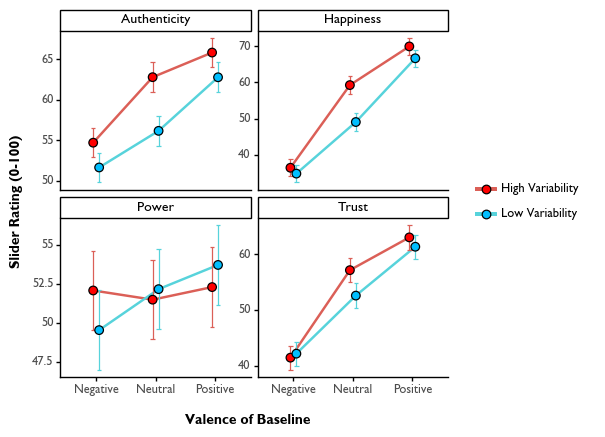

<ggplot: (-9223371915974333927)>

In [35]:
# Use plotnine package to plot using ggplot2 (R) style ...
(ggplot(plotData, aes(x='valence', y='slider_mean', fill='variability', group='variability', color='variability'))
 + geom_line(size=1, position=position_dodge(0.2))
 + geom_errorbar(aes(ymin='slider_mean-slider_sem', ymax='slider_mean+slider_sem', color='variability'), width=0.15, position=position_dodge(0.2))
 + geom_point(shape='o', color='black', size=3, stroke=0.5, position=position_dodge(0.2), alpha=1)
 + scale_fill_manual(values=["red", "deepskyblue"])
 + facet_wrap('~rating_type', scales='free_y', nrow=2, ncol=2)
 + labs(y='Slider Rating (0-100)\n', x='\nValence of Baseline') 
 + theme_classic()
 + theme(figure_size = (5, 4.5),
         text = element_text(family='Gill Sans MT'), 
         axis_text_x = element_text(size=9), 
         axis_text_y = element_text(size=9), 
         axis_title_x = element_text(weight='bold', size=10), 
         axis_title_y = element_text(weight='bold', size=10),
         axis_line_y = element_line(color='black'),
         legend_title = element_blank(),
         legend_text = element_text(size=9),
         legend_position = 'right',
         strip_background = element_rect(fill='white'),
         strip_text_x = element_text(size=10, color='black'))) 
  

In [36]:
# Create new dataframe for figure showing high vs. low variability stimulus distributions, faceted by valence:
negDistData = pd.DataFrame({
    'feature': np.repeat(np.linspace(-100, 100, num=41), [2]*41),
    'emotion': ['Angry']*40 + ['Neutral']*2 + ['Happy']*40,
    'variability': ['High Variability', 'Low Variability']*41,
    'valence': ['Negative']*82,
    'count': [0]*82
})

negDistData.loc[(negDistData['variability']=='High Variability') & (negDistData['feature']<=0), ['count']] = 1
negDistData.loc[(negDistData['variability']=='High Variability') & (negDistData['feature']==-50), ['count']] = 0
negDistData.loc[(negDistData['variability']=='Low Variability') & ((negDistData['feature']>=-60) & (negDistData['feature']<=-40)), ['count']] = 4

negDistData

,count,emotion,feature,valence,variability
0,1,Angry,-100.0,Negative,High Variability
1,0,Angry,-100.0,Negative,Low Variability
2,1,Angry,-95.0,Negative,High Variability
3,0,Angry,-95.0,Negative,Low Variability
4,1,Angry,-90.0,Negative,High Variability
5,0,Angry,-90.0,Negative,Low Variability
6,1,Angry,-85.0,Negative,High Variability
7,0,Angry,-85.0,Negative,Low Variability
8,1,Angry,-80.0,Negative,High Variability
9,0,Angry,-80.0,Negative,Low Variability


In [37]:
# Make similar dataframes for neutral and positive valence conditions:
neutDistData = pd.DataFrame({
    'feature': np.repeat(np.linspace(-100, 100, num=41), [2]*41),
    'emotion': ['Angry']*40 + ['Neutral']*2 + ['Happy']*40,
    'variability': ['High Variability', 'Low Variability']*41,
    'valence': ['Neutral']*82,
    'count': [0]*82
})

neutDistData.loc[(neutDistData['variability']=='High Variability') & ((neutDistData['feature']>=-50) & (neutDistData['feature']<=50)), ['count']] = 1
neutDistData.loc[(neutDistData['variability']=='High Variability') & (neutDistData['feature']==0), ['count']] = 0
neutDistData.loc[(neutDistData['variability']=='Low Variability') & ((neutDistData['feature']>=-10) & (neutDistData['feature']<=10)), ['count']] = 4

neutDistData

,count,emotion,feature,valence,variability
0,0,Angry,-100.0,Neutral,High Variability
1,0,Angry,-100.0,Neutral,Low Variability
2,0,Angry,-95.0,Neutral,High Variability
3,0,Angry,-95.0,Neutral,Low Variability
4,0,Angry,-90.0,Neutral,High Variability
5,0,Angry,-90.0,Neutral,Low Variability
6,0,Angry,-85.0,Neutral,High Variability
7,0,Angry,-85.0,Neutral,Low Variability
8,0,Angry,-80.0,Neutral,High Variability
9,0,Angry,-80.0,Neutral,Low Variability


In [38]:
posDistData = pd.DataFrame({
    'feature': np.repeat(np.linspace(-100, 100, num=41), [2]*41),
    'emotion': ['Angry']*40 + ['Neutral']*2 + ['Happy']*40,
    'variability': ['High Variability', 'Low Variability']*41,
    'valence': ['Positive']*82,
    'count': [0]*82
})

posDistData.loc[(posDistData['variability']=='High Variability') & (posDistData['feature']>=0), ['count']] = 1
posDistData.loc[(posDistData['variability']=='High Variability') & (posDistData['feature']==50), ['count']] = 0
posDistData.loc[(posDistData['variability']=='Low Variability') & ((posDistData['feature']>=40) & (posDistData['feature']<=60)), ['count']] = 4

posDistData

,count,emotion,feature,valence,variability
0,0,Angry,-100.0,Positive,High Variability
1,0,Angry,-100.0,Positive,Low Variability
2,0,Angry,-95.0,Positive,High Variability
3,0,Angry,-95.0,Positive,Low Variability
4,0,Angry,-90.0,Positive,High Variability
5,0,Angry,-90.0,Positive,Low Variability
6,0,Angry,-85.0,Positive,High Variability
7,0,Angry,-85.0,Positive,Low Variability
8,0,Angry,-80.0,Positive,High Variability
9,0,Angry,-80.0,Positive,Low Variability


In [39]:
# Create combined dataframe for plotting of stimulus distributions:
stimDistData = pd.concat([negDistData, neutDistData, posDistData], axis=0)
stimDistData

,count,emotion,feature,valence,variability
0,1,Angry,-100.0,Negative,High Variability
1,0,Angry,-100.0,Negative,Low Variability
2,1,Angry,-95.0,Negative,High Variability
3,0,Angry,-95.0,Negative,Low Variability
4,1,Angry,-90.0,Negative,High Variability
5,0,Angry,-90.0,Negative,Low Variability
6,1,Angry,-85.0,Negative,High Variability
7,0,Angry,-85.0,Negative,Low Variability
8,1,Angry,-80.0,Negative,High Variability
9,0,Angry,-80.0,Negative,Low Variability


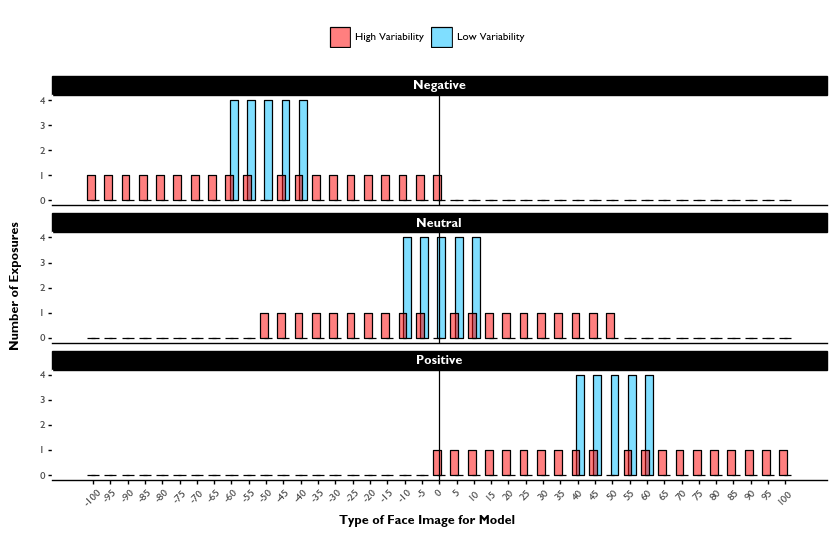

<ggplot: (-9223371915974386204)>

In [40]:
# Generate figure for high vs. low variability stimulus presentation distributions, faceted by valence:
(ggplot(stimDistData, aes(x='feature', y='count', fill='variability'))
 + geom_bar(stat='identity', position=position_dodge(width=2.5), alpha=0.5, color='black')
 + scale_fill_manual(values = ['red', 'deepskyblue'])
 + geom_vline(xintercept=0, color='black')
 + scale_x_continuous(breaks=np.linspace(-100, 100, num=41), labels=np.linspace(-100, 100, num=41).astype(int))
 + scale_y_continuous(limits=[0, 4])
 + facet_wrap('~valence', nrow=3)
 + theme_classic()
 + labs(x='Type of Face Image for Model', y='Number of Exposures\n')
 + theme(figure_size = (10,5),
         text = element_text(family='Gill Sans MT'),
         axis_text_x = element_text(size=8, angle=45),
         axis_title_x = element_text(size=9, weight='bold'),
         axis_text_y = element_text(size=8),
         axis_title_y = element_text(size=9, weight='bold'),
         axis_line_x = element_line(color='black'),
         axis_line_y = element_line(color='white'),
         legend_title = element_blank(),
         legend_text = element_text(size=8),
         legend_position = 'top',
         strip_text_x = element_text(weight='bold', color='white', size=9), 
         strip_background = element_rect(fill='black')))